In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
import pprint
import scipy
from scipy import stats
import numpy as np
import math

In [2]:
import ast
import re

In [3]:
def convert_to_list(data):
    """
    Hàm này chuyển đổi một chuỗi có định dạng list thành một list thực sự.
    Nó sẽ xử lý các lỗi và trả về một list rỗng nếu dữ liệu đầu vào không hợp lệ.
    """
    # Chỉ xử lý nếu dữ liệu là một chuỗi (str)
    if isinstance(data, str):
        try:
            # Thử chuyển đổi chuỗi thành list
            return ast.literal_eval(data)
        except (ValueError, SyntaxError):
            # Nếu có lỗi (ví dụ: chuỗi không đúng định dạng), trả về một list rỗng
            return []
    # Nếu dữ liệu không phải là chuỗi (ví dụ: NaN), cũng trả về list rỗng
    return []

def remove_dotted_words(name_string: str) -> str:
    """
    Removes standalone words ending with a period (like initials or suffixes)
    from a string.

    Args:
        name_string: The input name string.

    Returns:
        The cleaned name string.
    """
    # 1. Find and remove any whole word ending in a period (e.g., "H.", "Jr.").
    #    The pattern \b[A-Za-z]+\. finds a word boundary, one or more letters,
    #    and a literal period.
    cleaned_name = re.sub(r'\b[A-Za-z]+\.', '', name_string)

    # 2. Clean up any extra whitespace that may have been left behind.
    #    The pattern \s\s+ finds two or more spaces and replaces them with one.
    cleaned_name = re.sub(r'\s\s+', ' ', cleaned_name)

    # 3. Remove any leading/trailing spaces or commas.
    return cleaned_name.strip(' ,')

def get_institution_from_dict(education_entry):
    """
    Safely extracts the 'institution' value from a dictionary.
    Returns np.nan if the entry is not a dictionary or the key is missing.
    """
    # Check if the entry is a dictionary
    if isinstance(education_entry, dict):
        # Use .get() which returns None (or a default) if the key doesn't exist.
        # This is safer than using education_entry['institution'], which would crash.
        return education_entry.get('institution')
    
    # Return a standard missing value if the entry is not a dictionary (e.g., None, NaN, a string)
    return np.nan

def convert_degree_to_list(text):
    """
    Converts a semicolon-separated string into a list of strings.

    Args:
        text: The input string to convert.

    Returns:
        A list of strings, with whitespace removed from each element.
        Returns an empty list if the input is not a string.
    """
    if not isinstance(text, str):
        return []
    
    # Split the string by the semicolon and strip whitespace from each item
    return [item.strip() for item in text.split(';')]

def find_degree_level(degree_string):
    """
    Identifies the academic degree level from an input string.

    Args:
        degree_string: The string to analyze.

    Returns:
        'doctor', 'master', 'bachelor', or None if no match is found.
    """
    if not isinstance(degree_string, str):
        return None

    # Convert the string to lowercase for case-insensitive matching
    lower_string = degree_string.lower()

    # Check for keywords in order of precedence (doctor > master > bachelor)
    if 'doctor' in lower_string or 'doctorate' in lower_string or 'doctoral' in lower_string or 'phd' in lower_string:
        return 'doctor'
    elif 'master' in lower_string:
        return 'master'
    elif 'bachelor' in lower_string:
        return 'bachelor'
    
    return None


In [4]:
df = pd.read_csv('astronauts.csv').drop(columns=['time_in_space'])
df_with_role = pd.read_csv('cleaned_astronaut_data_complete.csv')


In [5]:
df['name'] = df['name'].apply(remove_dotted_words)

In [6]:
df_roles = df_with_role[['cleaned_name', 'Mission.Role']].copy().dropna()
df_roles['Mission.Role'] = df_roles['Mission.Role'].str.lower().replace(
    {'other': 'tourist', 'spaceflight participant': 'tourist', 'participant': 'tourist', 'tourist': 'tourist', 
        'other (space tourist)': 'tourist', 'other (journalist)': 'journalist'
    }
)
print(df_roles.head())

         cleaned_name Mission.Role
0        Yuri Gagarin        pilot
1       Gherman Titov        pilot
2   Glenn John H. Jr.        pilot
3   Glenn John H. Jr.          psp
4  M. Scott Carpenter        pilot


In [7]:
df_roles['cleaned_name'] = df_roles['cleaned_name'].apply(remove_dotted_words)

In [8]:
df_roles['Mission.Role'].unique()

array(['pilot', 'psp', 'commander', 'msp', 'flight engineer',
       'journalist', 'tourist'], dtype=object)

<Axes: xlabel='Mission.Role', ylabel='count'>

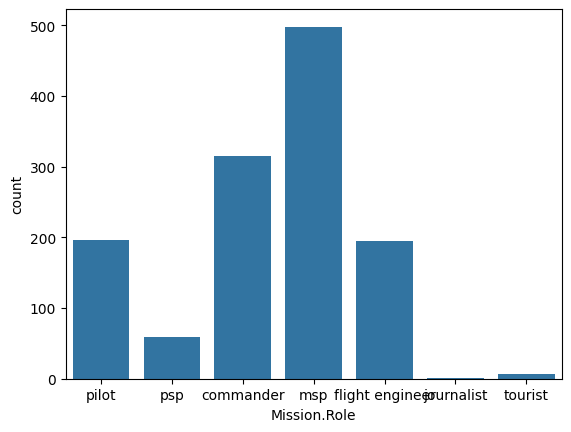

In [9]:
sns.countplot(x = 'Mission.Role', data = df_roles)

In [10]:
df = pd.merge(df, df_roles, left_on='name', right_on='cleaned_name', how='inner')

In [11]:
df['degrees'] = df['degrees'].apply(convert_to_list)
df['occupations'] = df['occupations'].apply(convert_to_list)
df['education'] = df['education'].apply(convert_to_list)
df['interests'] = df['interests'].apply(convert_to_list)

#Study relationship between roles and degrees

In [12]:
df_degrees = pd.read_csv('astronauts_with_degree_level.csv')[['name', 'degrees']]


In [13]:
df_degrees['degrees'] = df_degrees['degrees'].apply(convert_degree_to_list)

In [14]:
df_degrees  = pd.merge(df_roles, df_degrees, left_on='cleaned_name', right_on='name', how='inner').explode('degrees').reset_index(drop=True).dropna()
df_degrees['degrees'] = df_degrees['degrees'].apply(find_degree_level)
df_degrees = df_degrees[df_degrees['degrees'].isna() == False]

In [15]:
degree_order = ['bachelor', 'master', 'doctor']

In [16]:
# Map degree to its order for sorting
degree_rank = {deg: i for i, deg in enumerate(degree_order)}

# Sort by cleaned_name and degree rank, then drop duplicates keeping the highest degree
df_degrees_sorted = df_degrees.copy()
df_degrees_sorted['degree_rank'] = df_degrees_sorted['degrees'].map(degree_rank)
df_degrees_sorted = df_degrees_sorted.sort_values(['cleaned_name', 'degree_rank'], ascending=[True, False])
df_degrees_unique = df_degrees_sorted.drop_duplicates(subset='cleaned_name', keep='first').drop(columns='degree_rank')

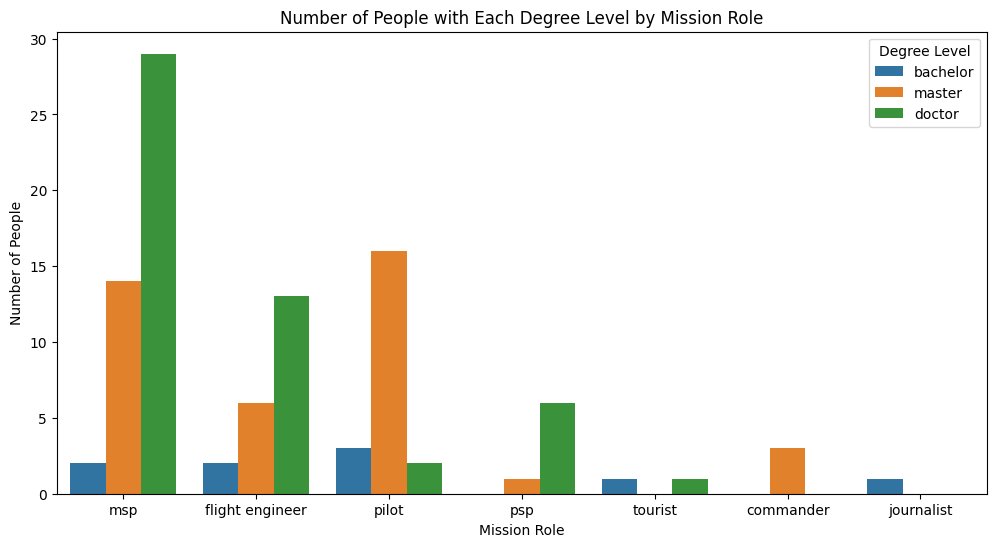

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Mission.Role',
    hue='degrees',
    data=df_degrees_unique,
    order=df_degrees_unique['Mission.Role'].unique(),
    hue_order=degree_order
)
plt.xlabel('Mission Role')
plt.ylabel('Number of People')
plt.title('Number of People with Each Degree Level by Mission Role')
plt.legend(title='Degree Level')
plt.show()

In [18]:
degree_df = pd.read_csv('astronauts_with_degrees (1).csv')

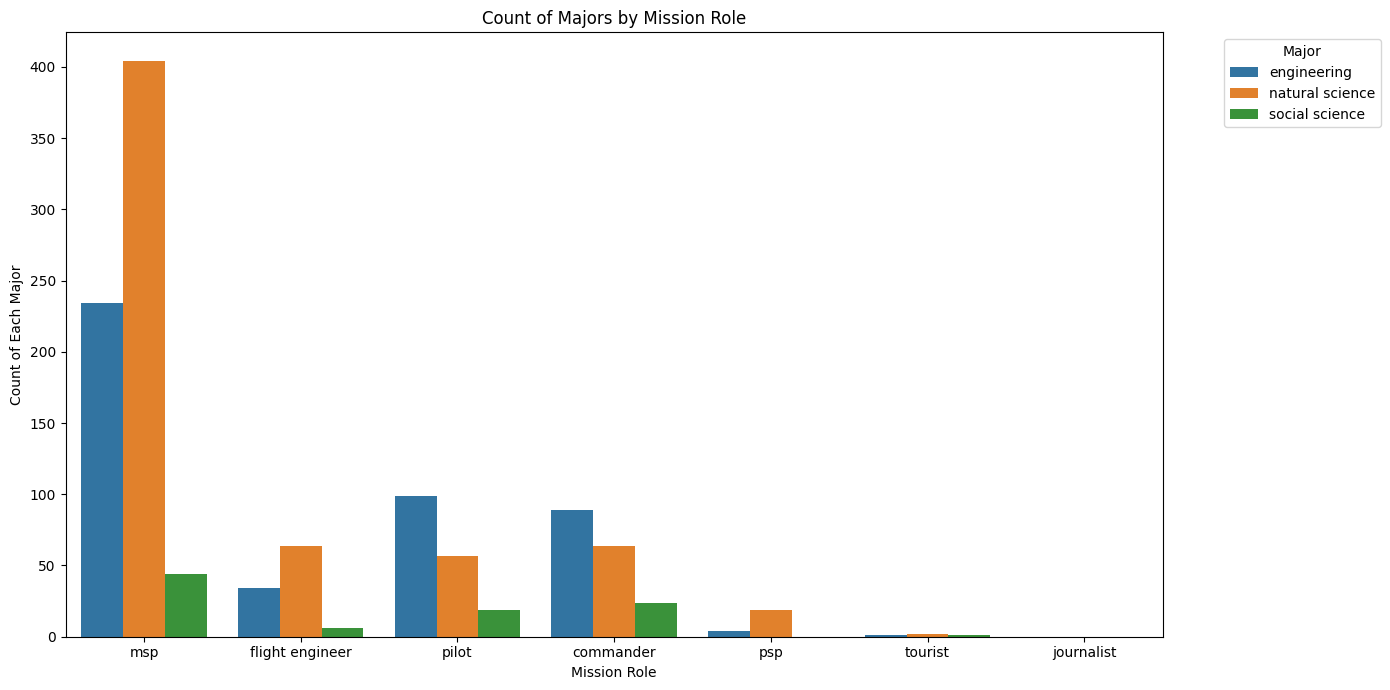

In [19]:
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Mission.Role',
    hue='major category',
    data=degree_df,
    order=degree_df['Mission.Role'].unique()
)
plt.xlabel('Mission Role')
plt.ylabel('Count of Each Major')
plt.title('Count of Majors by Mission Role')
plt.legend(title='Major', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Study relationship between roles and hobbies

In [20]:
df_interest_with_category = pd.read_csv('astronauts_interests_recategorized_out.csv')

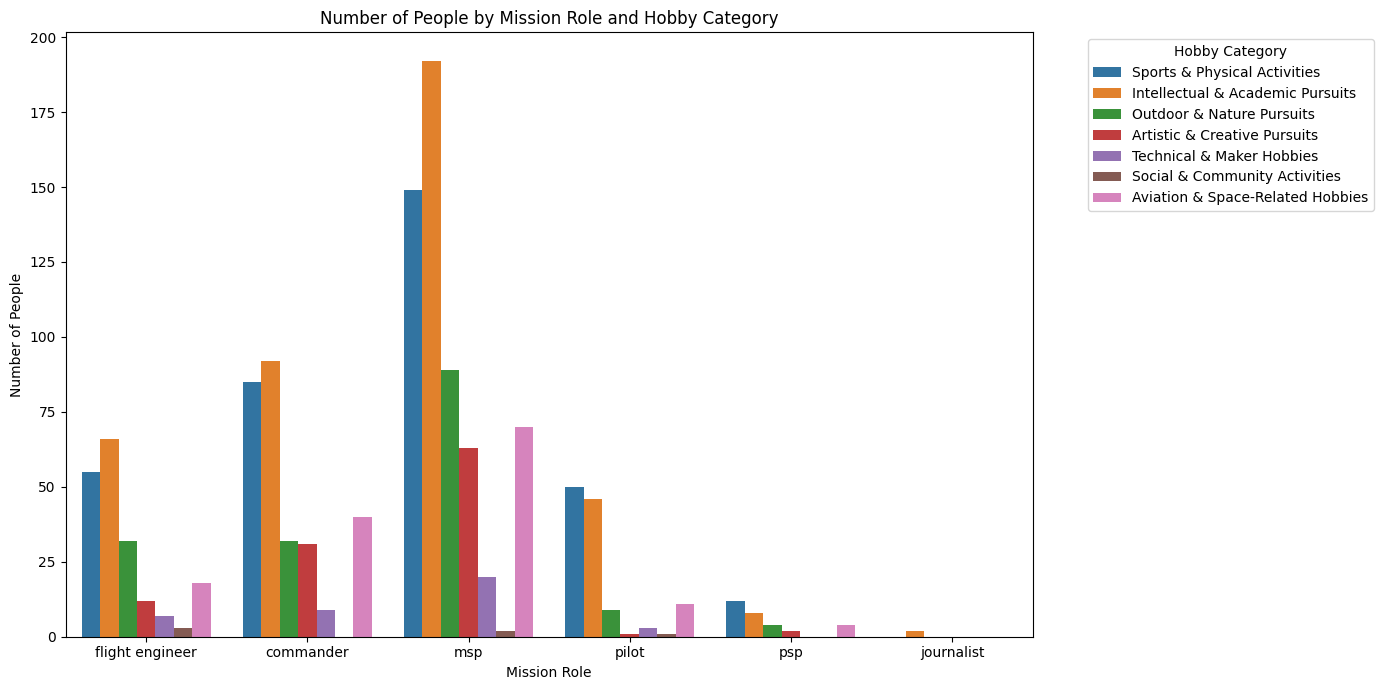

In [21]:
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Mission.Role',
    hue='Hobby Category (Recategorized)',
    data=df_interest_with_category,
    order=df_interest_with_category['Mission.Role'].unique()
)
plt.xlabel('Mission Role')
plt.ylabel('Number of People')
plt.title('Number of People by Mission Role and Hobby Category')
plt.legend(title='Hobby Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Study relationship between roles and schools

In [22]:
df_education = df.drop(columns=['degrees','occupations','interests'], axis=1).explode('education').reset_index(drop=True).dropna()

In [23]:
df_education['institution'] = df_education['education'].apply(get_institution_from_dict)


In [24]:
df_education = df_education.drop(columns=['education'])

In [25]:
institution_counts = df_education['institution'].value_counts().sort_values(ascending=False)

institution_counts[:15,]

institution
Massachusetts Institute of Technology         62
United States Naval Academy                   60
United States Air Force Academy               60
Purdue University                             49
Stanford University                           40
Rice University                               28
Naval Postgraduate School                     27
University of Washington                      25
U.S. Naval Postgraduate School                23
Moscow Aviation Institute                     22
Moscow Institute of Physics and Technology    19
University of West Florida                    17
University of Virginia                        17
University of California, Los Angeles         17
California Institute of Technology            16
Name: count, dtype: int64